<a href="https://colab.research.google.com/github/shamim-ice/SPEECH_ENHANCEMENT_MVDR_BEAMFORMING/blob/master/speechEnhancementBeamforming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview
This is a tutorial on applying Minimum Variance Distortionless Response (MVDR) beamforming to estimate enhanced speech with TorchAudio.

Steps:

Generate an ideal ratio mask (IRM) by dividing the clean/noise magnitude by the mixture magnitude.

Estimate power spectral density (PSD) matrices using torchaudio.transforms.PSD()

Estimate enhanced speech using MVDR modules (torchaudio.transforms.SoudenMVDR()).

Benchmark the two methods (torchaudio.functional.rtf_evd() and torchaudio.functional.rtf_power()) for computing the relative transfer function (RTF) matrix of the reference microphone.

#Import the packages

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

1.12.1+cu113
0.12.1+cu113


In [ ]:
!pip3 install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 6.1 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=d5ba69c32e7a050b7f63db87926d1ad5f7ceb78fe0a01949ad8ba4906ac3f4e2
  Stored in directory: /root/.cache/pip/wheels/18/5a/46/d2527ff1fd975e1a793375e6ed763bfe4d3ea396b7cdc470eb
Successfully built mir-eval


In [ ]:
!pip3 install pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pesq: filename=pesq-0.0.4-cp37-cp37m-linux_x86_64.whl size=214584 sha256=92ea344b2a5468065eb7f62a17317b33ea7513a56801a132387784e2e3bcc7e5
  Stored in directory: /root/.cache/pip/wheels/c5/3d/9c/542731f8357f7c82eb6ac2047cc5375f92c9a05b09a715aff6
Successfully built pesq


In [ ]:
!pip3 install pystoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7793 sha256=429a026d1a64bf78897afde6783d255436c49fb38c279ab47326b27144e2280d
  Stored in directory: /root/.cache/pip/wheels/46/4a/ad/3ab460193ed0535430b4b1575f255aa6bae69df17453628e86
Successfully built pystoi


In [ ]:
from pesq import pesq
from pystoi import stoi
import mir_eval

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

#Download audio data

In [ ]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

  0%|          | 0.00/0.98M [00:00<?, ?B/s]

  0%|          | 0.00/1.95M [00:00<?, ?B/s]

#Plot spectrogram 

In [ ]:
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

#plot mask

In [ ]:
def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

#Compute si_snr

In [ ]:
def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()

#Generate noisy signal

In [ ]:
def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise

#Evaluate SDR, PESQ, STOI

In [ ]:

def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

#Load audio data

In [ ]:
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)

In [ ]:
num_channels, num_frames = waveform_mix.shape
print(num_channels,num_frames)

8 64000


In [ ]:
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

#Compute STFT coefficients

In [ ]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

#Visualize noisy signal

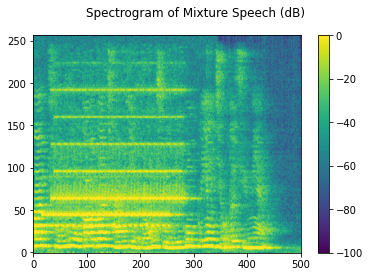

SDR score: 4.140362181778013
Si-SNR score: 4.104058905536078
PESQ score: 2.0084526538848877
STOI score: 0.7724339398714715


In [ ]:
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

#visualize speech signal

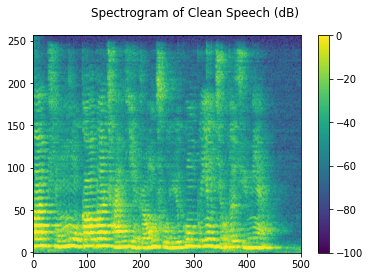

In [ ]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

#visualize noise signal

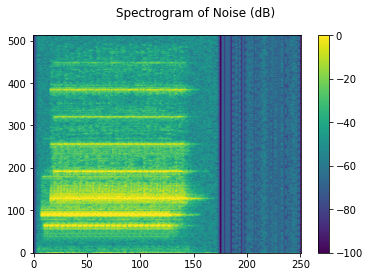

In [ ]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

#Define reference channel

In [ ]:
REFERENCE_CHANNEL = 0

#Compute ideal ratio mask (IRM)

In [ ]:
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]


irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

#Visualize IRM of target speech

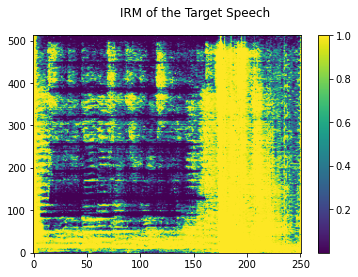

In [ ]:
plot_mask(irm_speech,'IRM of the Target Speech')

#Visualize IRM of noise

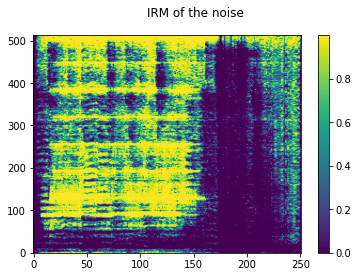

In [ ]:
plot_mask(irm_noise,'IRM of the noise')

#Compute PSD matrices
torchaudio.transforms.PSD() computes the time-invariant PSD matrix given the multi-channel complex-valued STFT coefficients of the mixture speech and the time-frequency mask.

The shape of the PSD matrix is (…, freq, channel, channel).

In [ ]:
psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

#Applying beamforming

In [ ]:
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, waveform_mix.shape[-1])

#Result for soudenMVDR

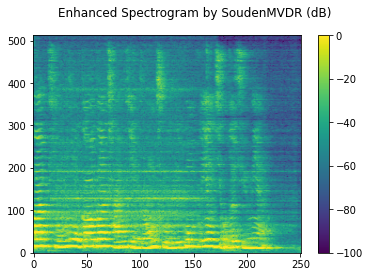

SDR score: 17.94623444134129
Si-SNR score: 12.215202605410084
PESQ score: 3.3447487354278564
STOI score: 0.8712864460530603


In [ ]:
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
evaluate(waveform_souden, waveform_clean[0:1])
Audio(waveform_souden, rate=SAMPLE_RATE)

In [ ]:
irm_speech

tensor([[1.0000, 1.0000, 0.9855,  ..., 0.9973, 0.9999, 1.0000],
        [1.0000, 1.0000, 0.9997,  ..., 0.9998, 0.9998, 1.0000],
        [1.0000, 1.0000, 0.9994,  ..., 0.9998, 0.9954, 1.0000],
        ...,
        [1.0000, 0.9992, 0.9808,  ..., 0.0891, 0.3881, 0.9899],
        [1.0000, 0.9988, 0.7678,  ..., 0.5055, 0.7401, 0.9365],
        [1.0000, 0.9988, 0.9610,  ..., 0.6226, 0.7144, 0.2118]],
       dtype=torch.float64)

In [ ]:
irm_speech.shape

torch.Size([513, 251])

In [ ]:
irm_noise.shape

torch.Size([513, 251])